In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import emcee
import pandas as pd

Notebook summary: more with mixture model photometry

In [2]:
ncat = pd.read_csv('ncat_240616.csv',index_col=None)

In [3]:
def gaussian_flux_model(theta, r):
    total_flux, sigma, background = theta
    #total_flux, background = theta
    return total_flux * (1 - np.exp(-r**2 / (2 * sigma**2))) + background * np.pi * r**2

def log_likelihood(theta, r, flux, flux_err):
    model = gaussian_flux_model(theta, r)
    return -0.5 * np.sum(((flux - model) / flux_err)**2)

def log_prior(theta):
    total_flux, sigma, background = theta
    if (0 < total_flux < 1000) and (1 < sigma < 3) and (0 < background < 100):
        return 0.0
    return -np.inf
    
def log_probability(theta, r, flux, flux_err):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, r, flux, flux_err)

In [4]:
def fit_aperture_curve(aperture_radii,flux,flux_err,
                       showplots=False, # show the walker plots
                       showstats=False, # print summary results
                       nsteps = 5000, # number of MCMC steps
                      ):
    # Set up the MCMC sampler
    ndim = 3  # Number of parameters to fit (total_flux, sigma, background)
    nwalkers = 32  # Number of MCMC walkers
    
    # Initialize the walkers
    initial_guess = [np.mean(flux), 5/2.355, (flux[-1]-flux[-2])/(np.pi * (aperture_radii[-1]**2-aperture_radii[-2]**2))]
    pos = initial_guess + 1e-4 * np.random.randn(nwalkers, ndim)
    
    # Run the MCMC sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(aperture_radii, flux, flux_err))
    sampler.run_mcmc(pos, nsteps, progress=True)

    if showplots:
        # Plot the MCMC results
        fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
        samples = sampler.get_chain()
        labels = ["Total Flux", "Sigma", "Background"]
        for i in range(ndim):
            ax = axes[i]
            ax.plot(samples[:, :, i], "k", alpha=0.3)
            ax.set_xlim(0, len(samples))
            ax.set_ylabel(labels[i])
            ax.yaxis.set_label_coords(-0.1, 0.5)
        axes[-1].set_xlabel("Step number")
        plt.tight_layout()
        plt.show()

    # Print the best-fit parameters
    flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
    if showstats:
        print("Best-fit parameters:")
        for i in range(ndim):
            mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
            q = np.diff(mcmc)
            print(f"{labels[i]}: {mcmc[1]:.3f} +{q[1]:.3f} -{q[0]:.3f}")
    return flat_samples

In [5]:
aperture_radii = np.array([1.5, 2.3, 3.8, 6.0, 9.0, 12.8, 17.3])
i = 40
flux = np.array([ncat[f'NUV_CPS_APER{a}'].iloc[i] for a,r in enumerate(aperture_radii)])
flux_err = np.array([ncat[f'NUV_CPS_ERR_APER{a}'].iloc[i] for a,r in enumerate(aperture_radii)])

In [6]:
flat_samples = fit_aperture_curve(aperture_radii,flux,flux_err)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1024.59it/s]


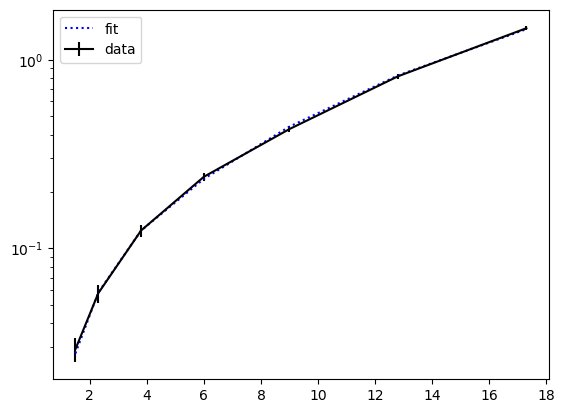

In [7]:
plt.figure()
plt.errorbar(aperture_radii,flux,yerr=flux_err,fmt='k-',label='data')
plt.plot(aperture_radii,
         gaussian_flux_model([np.percentile(flat_samples[:, 0], [16, 50, 84])[1],
                              np.percentile(flat_samples[:, 1], [16, 50, 84])[1],
                              np.percentile(flat_samples[:, 2], [16, 50, 84])[1],], aperture_radii),'b:',label='fit')
plt.legend()
plt.semilogy();

In [ ]:
np.random.seed(420)
models = pd.DataFrame({})
for i in np.arange(len(ncat)):
    flux = np.array([ncat[f'NUV_CPS_APER{a}'].iloc[i] for a,r in enumerate(aperture_radii)])
    flux_err = np.array([ncat[f'NUV_CPS_ERR_APER{a}'].iloc[i] for a,r in enumerate(aperture_radii)])
    flat_samples = fit_aperture_curve(aperture_radii,flux,flux_err)
    
    #plt.figure()
    #plt.errorbar(aperture_radii,flux,yerr=flux_err,fmt='k-',label='data')
    a,b,c = (np.percentile(flat_samples[:, 0], [16, 50, 84])[1],
             np.percentile(flat_samples[:, 1], [16, 50, 84])[1],
             np.percentile(flat_samples[:, 2], [16, 50, 84])[1])
    #plt.plot(aperture_radii,
    #         gaussian_flux_model([a,b,c,], aperture_radii),'b:',
    #         label=f'flux,sigma,bg= ({a:.3f} {b:.3f} {c:.3f})')
    models = pd.concat([models,
                        pd.DataFrame({'cps':[a],
                                      'sigma':[b],
                                      'bg':[c],
                                      'bg_aper':[(flux[-1]-flux[-2])/(np.pi * (aperture_radii[-1]**2 - aperture_radii[-2]**2))],
                                      })],
                       axis=0)
    #plt.legend()
    #plt.semilogy();

 30%|██████████████████████████████▍                                                                      | 1504/5000 [00:01<00:03, 1020.41it/s]

(0.0, 1.0)

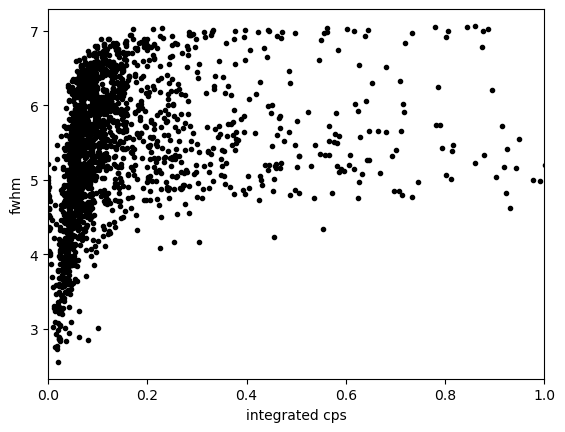

In [18]:
plt.plot(models['cps'],models['sigma']*2.355,'k.')
plt.xlabel('integrated cps')
plt.ylabel('fwhm')
plt.xlim([0,1])

In [15]:
models['cps'].max()

445.65027492042384

(0.001, 0.003)

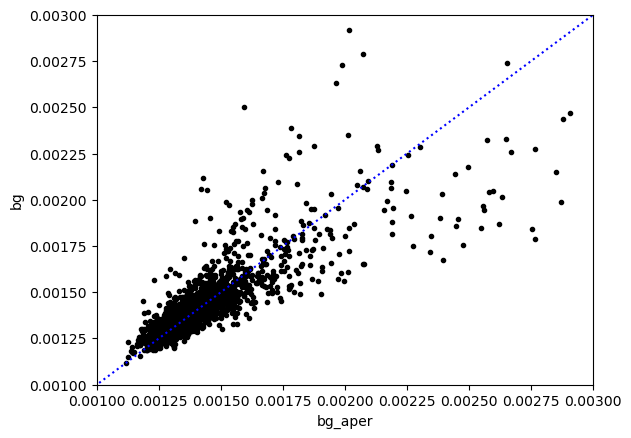

In [22]:
plt.plot(models['bg_aper'],models['bg'],'k.')
plt.plot([0,1],[0,1],'b:')
plt.xlabel('bg_aper')
plt.ylabel('bg')
plt.xlim([0.001,0.003])
plt.ylim([0.001,0.003])